# 对比性测试

## 概念

### ***CommonNarsese***

- 由[Narsese Grammar (IO Format)](https://github.com/opennars/opennars/wiki/Narsese-Grammar-(Input-Output-Format))定义，
- 在各类NARS(Narsese)实现中，
- 最先产生规范，并最为广泛接受的一种语法

与其它方言、超集的不同点举例：
- 原子词项：
    - 一律使用`$`、`#`、`?`、`^`区分「独立变量」「非独变量」「查询变量」「操作」
    - 一律使用单独的`_`表示「像占位符」
- 复合词项：
    - 一律使用特殊括弧`{词项...}`、`[词项...]`表示「外延集」「内涵集」
    - 一律使用「圆括号+前缀表达式」`(连接符, 词项...)`形式表示「非外延集、内涵集的复合词项」
        - 如`(&, <A --> B>, ^op)`
        - 对「否定」不使用前缀表达式
        - 对其它「二元复合词项」不使用中缀表达式
- 陈述：
    - 一律使用尖括号表示陈述，没有其他选项
        - 如`<A --> B>`
    - 不使用「回顾性等价」`<\>`系词
        - 一律用表义能力等同的「预测性等价」`</>`系词代替
        - 如`<A <\> B>`将表示为`<B </> A>`


## 导入

In [26]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

In [27]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [28]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 3


4

In [29]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [30]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

randomTruth() = JuNarsese.default_precision_truth(rand(0.01:0.01:0.99, 2)...)
randomBudget() = JuNarsese.default_precision_budget(rand(0.01:0.01:0.99, 3)...)
randomTense() = @rand [
    TensePast
    TensePresent
    TenseFuture
    TenseEternal
]

randomStamp() = JuNarsese.StampBasic{randomTense()}() # 暂仅支持随机时态

function random_wrap_sentence(term::Term)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(term; truth = randomTruth(), stamp = randomStamp())
end

function random_wrap_task(sentence::ASentence)
    TaskBasic(sentence; budget = randomBudget())
end

randomSentence(depth=3, width=3) = random_wrap_sentence(randomStatement(depth-1, width))
randomTask(depth=3, width=3) = random_wrap_task(randomSentence(depth-1, width))


function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
        randomTask(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 <<<<$hae <-> phvdkxy> <=> <#watzkq --> mrzaz>> ==> <^nls <-> ^tgvhx>> ==> <<^tod <-> ?vwtznyrdjh> ==> <<^eah <-> ^sijybgcwdg> ==> <$ekbzu <-> ?lpzr>>>>! :/: %0.53;0.85%
 (--, <^yfybl --> ?osce>)
 $0.59;0.75;0.43$ <<^claxsrild <-> $zi> <=> <<$k <-> #m> ==> <doydayjtqj <-> ^od>>>@ :/:
 $0.19;0.06;0.58$ <<iv <-> $ti> ==> <#cqghjff --> cxr>>@ :/:
 $0.15;0.7;0.61$ <<^wzwyzhi <-> #y> <=> <<$bttk <-> ?vwbhsqkuzf> ==> <dyuarui <-> $f>>>@ :\:
 <(|, $aatvxul, ?nit, #vgkijaeb) --> ^thsrjrn>! %0.71;0.68%
 (--, <(~, pks, ?d) --> ?iwou>)
 <(-, #jr, $mvpdcnbtmp) <-> $y>@
 <{$kgnbmilnz, ^llrpeygbrw, ^r} --> (-, #ckxmpbx, ?ucbjqaiexo)>@ :\:
 <<(/, _, ?aocpxtqlz) <-> ^vttyowwbs> <=> <<?ehtvfasq <-> $wzdjnk> ==> <neybsj --> #urnuh>>>? :\:

生成测试集

In [31]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 先生成随机词项，然后再将部分词项修改成语句、任务
    for _ in 1:N
]

randomNarsese(D, W) = $0.62;0.14;0.66$ <(/, <<<^cxl <-> $mtmlm> ==> <?cghd --> ?fscvrfje>> ==> <$ok <-> ?pp>>, _) <-> ^v>? :\:


500-element Vector{AbstractTerm}:
 <<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>
 (-, (/, (\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\, (\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))
 <#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>
 (--, <$pkjjqm --> (\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdk

## 评估函数

#### 导入数据分析工具：DataFrames

In [32]:
using DataFrames

测试：使用具名元组直接添加行

In [33]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


#### 构造测试用表

In [34]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

Row,original_term,string
,Abstract…,String
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>"
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))"
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>"
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)"
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)"
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)"
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <<$eznbgycuv --> #wevlq> <=> <hdrkuh

In [35]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)",18
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <

#### 增加「非CommonNarsese语法」：更能体现出解析器通用性的语法

1. 无连接符复合词项⇒乘积：`(A, B)`⇔`(*, A, B)`

In [36]:
# 无连接符复合词项⇒乘积 #
# 📝直接使用「布尔索引」对切片进行操作

# 使用 map() 函数对 test_set_extra1 中的 string 列进行操作，返回一个新数据表
# 将其中符合正则表达式 r"\(\*\W*," 的字符串替换为 "(*,"
test_set_extra1_string = map(test_set.string) do x
    replace(x, r"\(\*\W*," => "(*,")
end

# 使用「布尔索引」来选择不等于原始 string 列的值
# 并将这些值替换为经过操作后的新值
# 注意：.≠ 运算符用于逐元素比较两个数组，生成一个布尔型数组
# test_set_extra1.string[test_set_extra1! .≠ test_set_extra1.string] = test_set_extra1![test_set_extra1! .≠ test_set_extra1.string]

#【20230819 20:07:04】现在直接把「能改成新格式」的数据增加到主数据集中
indices = test_set_extra1_string .≠ test_set.string # 索引：只获取「会被改变的词项」

test_set_extra1 = test_set[indices, :] |> deepcopy

test_set_extra1.string = test_set_extra1_string[indices]

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra1
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)",18
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <

2. 随机添加空白字符：空格` `、换行`\r`、回车`\n`、换页`\f`、水平制表符`\t`、垂直制表符`\v`

In [37]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)",18
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <

3. 按一定比例随机选取词项，提升成**语句**、**任务**（遵循CommonNarsese语法）
- 这样可以保留语法复杂度等信息

In [38]:
# 随机选取行
rand_sentences = DataFrame(rand(eachrow(test_set), 100))
rand_tasks = DataFrame(rand(eachrow(test_set), 100
))

# 打包，原地赋值
rand_sentences.original_term = rand_sentences.original_term .|> random_wrap_sentence
rand_tasks.original_term = rand_tasks.original_term .|> random_wrap_sentence .|> random_wrap_task

# 更新字符串
rand_sentences.string = string.(rand_sentences.original_term)
rand_tasks.string = string.(rand_tasks.original_term)

test_set = [ # 拼接
    test_set # 原本
    rand_sentences
    rand_tasks
]

Row,original_term,string,complexity
,Any,String,Int64
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)",18
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <<$eznb

In [39]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Any,String,Int64
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16
6,"(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)","(--, <<(/, _, [$dbwof, ?njdedkekq]) <-> (\\, (--, <?cxzsykcz --> $nggl>), <<^ta --> rqwf> ==> <#nehwotf <-> ?qulwcda>>, _, (--, <bmhvnaqvm <-> ?vdwz>))> ==> <^dueeweqyi --> ?mikovvre>>)",18
7,"(/, (--, <intlua --> (\\, <<^jqalemw --> #slbpwnik> ==> <?fxbki <-> $tktpysq>>, (--, <yhytjlgba --> #zixezmhrx>), (--, <la --> ?wriuthrbhp>), _)>), (--, <#qr --> ?hsubo>), _, [(/, (~, degetgxshs, ?giftqpote), <$qyjnlsqga <-> #vcrytula>, (--, <suqjjpltty --> ?tdqrqvmqa>), (~, #vvkmdejn, eh), _, (\\, _, $jdl, ^eibidfi, ?p, ?nggkrmbjm, ?wbivpbg, lkgxu, $eohi), {$f, #imqix, $onxaxcofjc, ?tiatkprqcu, $vx, #wxc, $xchdvte}, (-, $xzldnhthlj, $cfhb), (\\, #djprfegwzk, _), (&, ^feqml, ?iundlbbah, jdb, #mnutakb, #mwbhrmnml, $nwur, ^outfpgqtxa, ?pkkyol, ^pqi, ^rcsaidsslh)), (--, <<?dnd --> lgweuf> ==> <<$xjec --> eohkwqr> ==> <pvifrur <-> ?zrepij>>>), <{?jfdm, kci, #z} <-> $ko>], (--, <(-, <$oey --> #us>, <<^b <-> #txipj> <=> <k <-> ?n>>) --> (/, (--, <^pbkpnwnt <-> ^qcnvxsih>), (--, <vpa --> ?plaxawmqye>), _, <^brl <-> ^ml>, <^keb <-> ^tmmnd>)>), <xtfj --> (~, (\\, _, #bpku, ?di), (--, <<$eznb

#### 构造评估函数

In [40]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "$(parser)：以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [41]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",0.0785044,missing
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",0.0639695,missing
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",0.0003085,missing
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",0.0833049,missing
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16,"(--, <<#b <-> (\\, _,

In [42]:
# 导入OpenJunars
isdefined(Main, :Junars) || begin
    push!(LOAD_PATH, "../../../OpenJunars/")
    import Junars
end
# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
@info "OpenJunars解析结果:" parsed_term typeof(parsed_term)

┌ Info: OpenJunars解析结果:
│   parsed_term = "<A-->B>"
│   typeof(parsed_term) = Junars.Gene.Inheritance
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\comparative_tests.ipynb:9


In [43]:
testParser!(Junars.parse_term, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>","<<(*, (/, $qcj, _, ^ayyqphi, ?rpczdcya, ^mdr), (/, _, $ykv, ^ybc), (--, <?xpl --> $lopsic>)) --> (-, (/, ckzm, _), (--, <$n --> ^hvun>))> <=> <<<(\\, ?farszryhw, _) <-> nievd> ==> <(-, #cq, #mmvc) --> (\\, ub, _, #kudjtjf, #zqinetajk, ^stl)>> ==> <(~, ^wadz, ?slibn) --> (&, jlczk, ?jzn, ?kel, ^lorkxaf, $lwp)>>>",32,"""<<(*,(/,\\$qcj,_,^ayyqphi,?rpczdcya,^mdr),(/,_,\\$ykv,^ybc),(¬,<?xpl-->\\$lopsic>))-->(-,(/,ckzm,_),(¬,<\\$n-->^hvun>))><=><<<(\\\\,?farszryhw,_)<->nievd>==><(-,#cq,#mmvc)-->(\\\\,ub,_,#kudjtjf,#zqinetajk,^stl)>>==><(~,^wadz,?slibn)-->(&,\\$lwp,?jzn,?kel,^lorkxaf,jlczk)>>>""",0.101048,missing
2,"(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))","(-, (/, (\\, _, (--, <<?v --> $er> ==> <stfqfffqw <-> #vcbw>>), (--, <<$dhddbdyjgz --> $rujmgvdu> ==> <^ovzr --> $apoqcyfn>>), <#dwyfqbrn --> ?hiqnruz>), <<<f --> $zujjywjcgq> ==> <^dkm <-> #nmfqikw>> ==> <blwytrj <-> ?nsyjg>>, _, (\\, (\\, _, niwypps, ?tewewq, soayrz), (~, ^j, $ybjmvxh), _)), (~, (--, <(-, $xejjaurazl, $freuwgy) <-> ?wfm>), <<$usdwzi <-> #vpmrakrke> <=> <<ennfkp <-> $ocolrdqjd> <=> <spjsbjwq --> #nb>>>))",39,"""(-,(/,(\\\\,_,(¬,<<?v-->\\$er>==><#vcbw<->stfqfffqw>>),(¬,<<\\$dhddbdyjgz-->\\$rujmgvdu>==><^ovzr-->\\$apoqcyfn>>),<#dwyfqbrn-->?hiqnruz>),<<<f-->\\$zujjywjcgq>==><#nmfqikw<->^dkm>>==><?nsyjg<->blwytrj>>,_,(\\\\,(\\\\,_,niwypps,?tewewq,soayrz),(~,^j,\\$ybjmvxh),_)),(~,(¬,<(-,\\$xejjaurazl,\\$freuwgy)<->?wfm>),<<#vpmrakrke<->\\$usdwzi><=><<\\$ocolrdqjd<->ennfkp><=><spjsbjwq-->#nb>>>))""",0.164409,missing
3,"<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>","<#c --> (-, (~, <^iiq --> ?dwl>, <jy <-> ^sukca>), <<nvomgrrg --> ^pkachw> ==> <^xhlciuwofy <-> $yvkuyyzr>>)>",14,"""<#c-->(-,(~,<^iiq-->?dwl>,<^sukca<->jy>),<<nvomgrrg-->^pkachw>==><\\$yvkuyyzr<->^xhlciuwofy>>)>""",0.0405087,missing
4,"(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)","(--, <$pkjjqm --> (\\, (--, <<<$muxmyigr --> ^jmcvwko> ==> <#ijkzv --> #pq>> ==> <^eatiia <-> jgkyo>>), (--, <(~, $ehdkyq, ?jv) --> ^ppaq>), (&, (--, <<$gp --> ?zwyhg> ==> <$lsl --> $ok>>), <yltwnas --> $ojsqqt>), (--, <(\\, #yiangqxpy, _, ?xyjiuwuxms, ?aktrq, #at, ^mj) --> #g>), _)>)",27,"""(¬,<\\$pkjjqm-->(\\\\,(¬,<<<\\$muxmyigr-->^jmcvwko>==><#ijkzv-->#pq>>==><^eatiia<->jgkyo>>),(¬,<(~,\\$ehdkyq,?jv)-->^ppaq>),(&,(¬,<<\\$gp-->?zwyhg>==><\\$lsl-->\\$ok>>),<yltwnas-->\\$ojsqqt>),(¬,<(\\\\,#yiangqxpy,_,?xyjiuwuxms,?aktrq,#at,^mj)-->#g>),_)>)""",0.0454738,missing
5,"(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)","(--, <<#b <-> (\\, _, <pdpgsxid <-> $xhjkal>)> ==> <(/, (*, $ebkzfz, ?surgtzm, ^kcwyefrmwd), (\\, _, $x, $lxyfeimkby), _, (--, <?fa <-> $vgtv>)) --> (&, <#yy --> ^ssdrvyx>)>>)",16,"""(¬,<<#b<->(\\\\,_,<\\$xhjkal<->pdpgsxid>)>==><(/,(*,\\$ebkzfz,?surgtzm,^kcwyefrmwd),(\\\\,_,\\$x,\\$lxyfeimkby),_,(¬,<\\$vgtv<->

## 对比性评估开始

In [44]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term  => "Junars",
    StringParser_ascii => "JuNarsese-Native",
    LarkParser_alpha   => "JuNarsese×Lerche",
    PikaParser_alpha   => "JuNarsese×PikaParser",
    PikaParser_ascii   => "JuNarsese-Native×PikaParser",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: Invalid input! <(*,$qcj,_,^ayyqphi,?rpczdcya,^mdr),(/,_,$ykv,^ybc),(--,<?xpl-->$lopsic>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (*,ofsnqrie,^xjapyp)<->ectrt>),(*,ltl,#rrhwiqs,^mxdouyttf),(--,<<^ebd<->?frxeiezyy><=><^qrsa-->?plhwnsmf>>),(--,<^czbkxbpdx<->#rcrwhju>),(--,<<?yftz-->$tumr>==><#vznhwea-->$yonhpfcr>>),(--,<^t-->dfon>),_,(--,<<?msby<->#onsvpo>==><^jxccmt<->?mndsqzf>>))),(/,<<<#c-->$lwowxf><=><#zbeptuad-->#r

┌ Error: Invalid input! <<^nztzzooyu-->^pfap><=><?wws-->#taeqlqukae>>>>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(-,$pbwbnxig,#og)<->bphj>),{(|,(--,<<?gkpsmlccao<->jefqg><=><nvyb-->?rxunke>>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?kwuhb<->#pasmsxconz>==><$iscdyfaodb-->$hx>>],(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$iscdyfaodb-->$hx>>],(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<^hkkhnhcz<->?smx>))}
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <^hkkhnhcz<->?smx>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\contro

┌ Error: Invalid input! (--,<(*,<$s-->^amivpjdj>),(--,<$gtdj-->?v>),{$glfq,$ipzlr,#viefesgiz},(--,<$lizkdyk<->#qytkbthwd>),<elstjdlj<->$kmqq>)-->hja>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <(*,<$s-->^amivpjdj>),(--,<$gtdj-->?v>),{$glfq,$ipzlr,#viefesgiz},(--,<$lizkdyk<->#qytkbthwd>),<elstjdlj<->$kmqq>)-->hja>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (--,<<<#cu<->?ztlopbpn><=><gkv<->tadwezpbxl>><=><e<->#ge>>)),<<#anl-->(|,#d)>==><<<<?aueh<->^vvgpjzjx>==><?sgs<->^y>><=><c<->#cqqwpyccco>><=><^frxgeekp<->$jympxbh>>>,(*
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! 

┌ Error: Invalid input! <<#xihy-->#yxzgabsyh>==><<gybqvppk-->$zwxbsb>==><$fcnd<->?zkggobf>>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<gybqvppk-->$zwxbsb>==><$fcnd<->?zkggobf>>>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$fcnd<->?zkggobf>>>),
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (\,$tgyenqyctz,$wjk,_,#oomotzd)),(\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <#h<->k>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$skzbzl<->yem>),<?hzsclz-->?qqruwe>)<->(\,<<?aqfwmqfbp<->oggjnc><=><#mekfpxttuh-->ff>>,(&
└ @ Junars.Control C:\Users\56506\.julia\pack

┌ Error: Invalid input! (\,_,(*,^p,^yjprvllc,^ezaluupcy,^alysecnlby,^fpzznagnya,knl,ygilbpx,sydf,?cgf,_,q),(\,^py,?ubunutkr,^xczjnpfdfq,?ijcsf,ohcpei,_,?ylicdkv,^yydtqsiv,$mvzmwirb,?muy),(--,<^q<->#wynwjkhn>),(--,<<$lk-->qquwyy>==><cvm<->^puc>>),(~,ggeie,?rac),(--,<$atdk<->ortezagrea>),(--,<<$salinkbkof<->#xgywmvnsy>==><?p-->$rnru>>),(~,^hh,ihluqss),(/,uzdo,yoawoygsyl,_,$byhs,$hff,exo))),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (/,uzdo,yoawoygsyl,_,$byhs,$hff,exo))),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<(-,#tox,^suikwyj)-->(&,$aoiqrcwpcn,#gdqawl,$lo,?nkbpcoi,#xgt)>==><fo<->qidsbnnt>><=><<<<#c<->?jg><=><?uuw-->gvmul>>==><$bs<->^vbwgqaphpx>><=><<<?crdaraznrv-->b><=><#rpa-->^bfgc>>==><<elvvwwor-->ifrdgs><=><$jfwledmif-->$n>>>>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\co

┌ Error: Invalid input! <y-->ozegzio>),_,{(--,<(~,sijotu,^iumejet)<->#dmfmyty>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^iao<->?pzrgkt>},<$tmorohna-->(*,$pse,$mrfj)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<$gouq-->$g>))>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <$gouq-->$g>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(*,?kopaxchsy,_),[^r],(~,$jsowbex,$klkczzu))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error

┌ Error: Invalid input! <(&,^gknfvo,$h,mp,$qkdsxrxchs,$wcjigwty)-->?gebiuhud>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <[?bvtm,$omovwwj,#tzutwmg,^yrji]-->(\,_,mbspfexrcz)>),<<<fy<->^gtywuzhmxi><=><ywd-->#mmffvd>><=><<#hbbdi<->?ihvj>==><$pynmoaxttx-->$gphmxj>>>,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (\,_,mbspfexrcz)>),<<<fy<->^gtywuzhmxi><=><ywd-->#mmffvd>><=><<#hbbdi<->?ihvj>==><$pynmoaxttx-->$gphmxj>>>,(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <$hyug<->$tpdqnmeazz>)),(-,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?duotsuuot-->^rvykwowr>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\chann

┌ Error: Invalid input! <<bftzodprb<->^ckszj><=><$kncsvnw-->$jvyvatrc>>),_),<$fgrgkt-->(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$kncsvnw-->$jvyvatrc>>),_),<$fgrgkt-->(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#q-->j>==><#pivla-->$vakpnfzb>>),(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <#pivla-->$vakpnfzb>>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^eietelsa<->?ooesyr>),_,<#ljwglvai<->?vaxo>,<<ljcmxbnlwt-->?gqgqyrah><=><^onl-->#arze>>,<<nxjdjym-->#uyaaq>==><?mtvo-->mr>>,(&
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?nd<->?ylvtkfyhjv>),<^bokdq

┌ Error: Invalid input! <(~,^aqbgzoojn,ak)-->(/,^lbbiugnonc,#vrwzwqkhy,_,^lcuxmyzdwb,^aiunflvf,#gilrzssfut)>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (/,^lbbiugnonc,#vrwzwqkhy,_,^lcuxmyzdwb,^aiunflvf,#gilrzssfut)>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139

└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233

└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$tjchyjyhhy-->$yfdhc>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?ecy<->phnyroty><=><$sjjoscncet-->^xjirfmtmt>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
-->(/,kvicwegu,?ueqjz,_,$hr,$sapfrra)>==>

┌ Error: Invalid input! <<<(\,_,tsfyox)-->(/,#byaduwpt,#he,?scwlqxzz,_,^hpjbmmbq,ptn)>==><<<#zd-->?adgrngyvd>==><?inasndpx-->#khhejfh>>==><^saww-->#pb>>>==><?cuypsj<->iuslxj>>>)@:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?cuypsj<->iuslxj>>>)@
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<<#t<->$xgpfkxu>==><<<<<?jtmsdxkeu-->eejswowsh>==><?vsy-->#qq>><=><?arglf<->^o>><=><<?ogujntyntc-->kpdoiugt>==><?dqwdxxy<->hvnfisb>>><=><<(\,$djlowls,$ag,$kwiydsg,#frwdk,pzmlpwb,_)-->ewvs><=><p<->?vkegvuhref>>>>).:|:%0.22;0.12%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<#t<->$xgpfkxu>==><<<<<?jtmsdxkeu-->eejswowsh>==><?vsy-->#qq>><=><?arglf<->^o>><=><<?ogujntyntc-->kpdoiugt>==><?dqwdxxy<->hvnfisb>>><=><<(\,$djlowls,$ag,$kwiydsg,#frwdk,pzmlp

┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! (\,?nrzzwmlo,_)}>>!:\:%0.73;0.
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (--,<[(&,(--,<?bwm<->$dosulax>),<$gwpqopc<->vy>),(--,<(|,^kreeke)<->$pkkelbegij>),(--,<#jdhgf-->(\,$hzirm,$hvgfmd,m,^llbn,_)>)]<->$ttmfgvsman>)?:|:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <[(&,(--,<?bwm<->$dosulax>),<$gwpqopc<->vy>),(--,<(|,^kreeke)<->$pkkelbegij>),(--,<#jdhgf-->(\,$hzirm,$hvgfmd,m,^llbn,_)>)]<->$ttmfgvsman>)?:|
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<^vzcuwttce-->$b>)@:|:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.j

┌ Error: Invalid input! (*,(-,(--,<<#gev<->?rjmvj><=><?jxdlakxk<->$l>>),(/,#zszqja,^dwr,_)),(&,(--,<<$tylhbn-->$hezdue>==><#jplcawmm-->$dmt>>),(|,?aplls,?khbhvdperc,$lyn,^m,nengdhtz,poueo,^vs,^yhpyvqmod,zymzg),<<?nuuigemn-->wtldnjtn>==><pggnk-->^q>>,<<#r-->izemtsi>==><^mtjgdwhp-->^owsdyzq>>,(\,^jh,_,ctludtjqrb,$ee,$bxospzuxa,^d),(--,<?hlmgbxby<->$rzf>),(--,<^oiqjguwu-->?a>),(--,<<#btbvo<->?cljcojfl><=><$xjztl<->$yymatt>>),(/,vvjxihsay,$cpvqw,_,$fvkfpml,^jnkz,#me,?yxzjl,^yfb,?owoiniaids,^caetdsqpbo)))).%0.45;0.91
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (&,(--,<<$tylhbn-->$hezdue>==><#jplcawmm-->$dmt>>),(|,?aplls,?khbhvdperc,$lyn,^m,nengdhtz,poueo,^vs,^yhpyvqmod,zymzg),<<?nuuigemn-->wtldnjtn>==><pggnk-->^q>>,<<#r-->izemtsi>==><^mtjgdwhp-->^owsdyzq>>,(\,^jh,_,ctludtjqrb,$ee,$bxospzuxa,^d),(--,<?hlmgbxby<->$rzf>),(--,<^oiqjguwu-->?a>),(--,<<#btbvo<->?cljcojfl><=><$xjztl<->$yymatt>>),(/,vvjxihsay,$cpvq

┌ Error: Invalid input! <<#bucwejey<->?cuv><=><<#a<->?lhsqmtnb><=><^wu<->?xcooqbw>>>))>).:/:%0.54;
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#a<->?lhsqmtnb><=><^wu<->?xcooqbw>>>))>).:/:%0.54
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^wu<->?xcooqbw>>>))>).:/:%0.5
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (&,<#lblgo-->?iubcab>,(\,(~,(\,axpiybrv,_,^nr),<<?dmmcvfho-->$avt>==><?wtpipanp-->#qhzcsgsrj>>),(\,(/,_,hxf,$vbyg,?wwnapj,^vsb,?dqbhcro),<<$eaxb<->^pjzee><=><#ehbxzvj<->#yfs>>,(--,<<lknebomjn-->^bvlbuncuz><=><qpvdqmedgb<->?t>>),_,(--,<<befpenqrq-->lcekihngfm>==><$xdgt-->$z>>),<<ucwisgch-->#jlltbmjwv><=><#zstbw-->^srxxoiwosk>>,(\,^d,_,wxp,^zw,^ngaesmb,#dewiitfv,hawnb,^qx),(--,<<?xtw-->^bzxosxpbhk>==><$nloot<->?zsqlrxma>>),(/,

┌ Error: Invalid input! <<(*,^lwp,#asrvdjdof,u,$sjpykyw)<->(|,#vrlfwys)><=><<<<#coevbwjhk<->$nmluabho>==><$bhscblh<->$unurijmk>>==><ppghcd<->$rf>><=><<<?qcvjkmb-->^yhngpidk><=><#smjkmcknsn<->$ys>>==><<bqo<->#tjmcmn>==><$ryn-->^fztkgjq>>>>>>.%0.58;0.92
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<<#coevbwjhk<->$nmluabho>==><$bhscblh<->$unurijmk>>==><ppghcd<->$rf>><=><<<?qcvjkmb-->^yhngpidk><=><#smjkmcknsn<->$ys>>==><<bqo<->#tjmcmn>==><$ryn-->^fztkgjq>>>>>>.%0.58;0.9
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<?qcvjkmb-->^yhngpidk><=><#smjkmcknsn<->$ys>>==><<bqo<->#tjmcmn>==><$ryn-->^fztkgjq>>>>>>.%0.58;0.
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<bqo<->#tjmcmn>==><$ryn-->^fztkgjq>>>>>>.%0.58;0
└ @ Junars.Control C:\Users\565

┌ Error: Invalid input! <<(/,(--,<$hgfqhpc-->likxexqeg>),_)<->(/,(--,<<^mhvwudm<->^mjn><=><#ybhfcxa-->?swuqji>>),_,<<#dsk<->$rordkrz><=><ehp<->^wirriitzt>>,(/,?pgtqt,^qyjkepo,_,?b,?szhyk))><=><<<<?ecy<->phnyroty><=><$sjjoscncet-->^xjirfmtmt>>==><#e-->^ffnxef>>==><(-,#rpsgsao,aa)<->cxbqyydy>>>)@:\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<<?ecy<->phnyroty><=><$sjjoscncet-->^xjirfmtmt>>==><#e-->^ffnxef>>==><(-,#rpsgsao,aa)<->cxbqyydy>>>)@:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(-,#rpsgsao,aa)<->cxbqyydy>>>)@
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<(-,(--,<#lgbdjex-->?zt>),<<<$z-->yq>==><#z-->?pvlsmcr>><=><?dqgygc-->?zihne>>)<->#tkrdnmiz>)@:\:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\contr

Excessive output truncated after 524564 bytes.

┌ Error: Invalid input! <(*,(~,(--,<<?dovphrpafq<->#jidlqzpv><=><rhfauplvew-->#mj>>),(--,<<aieua-->$pimka><=><$iwlgsnwhb<->^phthit>>)))-->(~,(--,<$e-->$gqqhfseq>),(--,<<<$irtufm-->^r><=><#j<->^lxfoofqhex>><=><<$ppk<->^xnhtul>==><#qbadbbmi-->?ud>>>))>?
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (~,(--,<$e-->$gqqhfseq>),(--,<<<$irtufm-->^r><=><#j<->^lxfoofqhex>><=><<$ppk<->^xnhtul>==><#qbadbbmi-->?ud>>>))>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<$irtufm-->^r><=><#j<->^lxfoofqhex>><=><<$ppk<->^xnhtul>==><#qbadbbmi-->?ud>>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <hukdzlqrqu<->^z>.:/:%0.55;0.5%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (

Dict{Any, Any} with 5 entries:
  parse_term         => 950×6 DataFrame…
  LarkParser_alpha   => 950×6 DataFrame…
  StringParser_ascii => 950×6 DataFrame…
  PikaParser_alpha   => 950×6 DataFrame…
  PikaParser_ascii   => 950×6 DataFrame…

## 比对结果分析、展示

In [45]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [46]:
print("解析成功的数据：")
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

5-element Vector{Pair{_A, Int64} where _A}:
 Junars.Control.parse_term => 817
          LarkParser_alpha => 622
        StringParser_ascii => 888
          PikaParser_alpha => 910
          PikaParser_ascii => 910

In [47]:
using CairoMakie

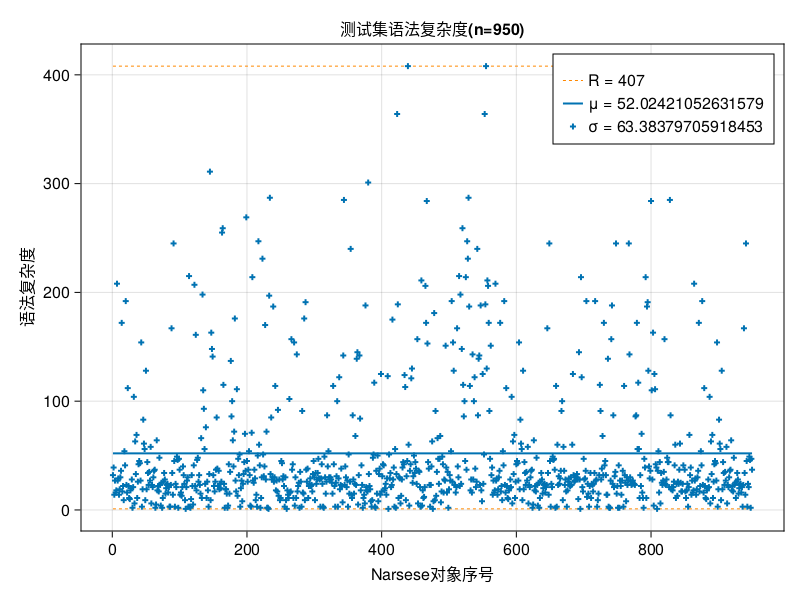

In [48]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度(n=$(size(test_set, 1)))"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "语法复杂度"

current_figure()

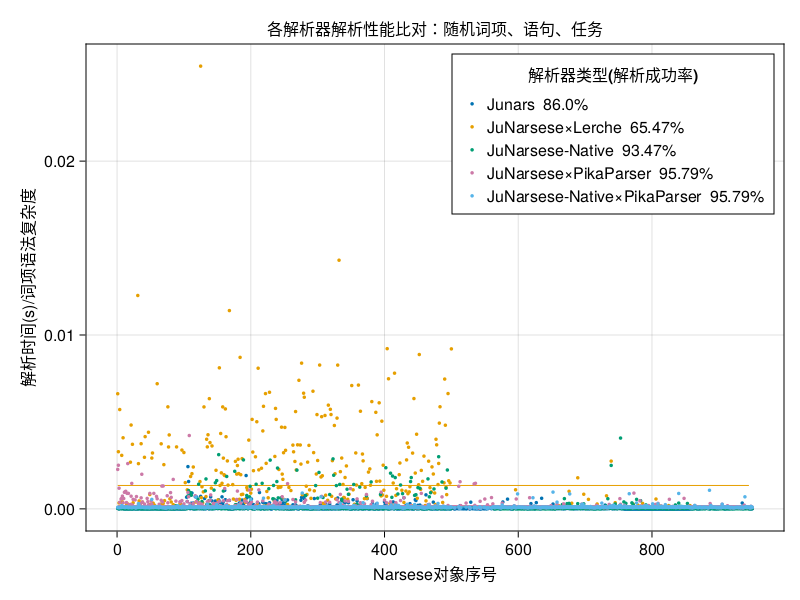

In [49]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

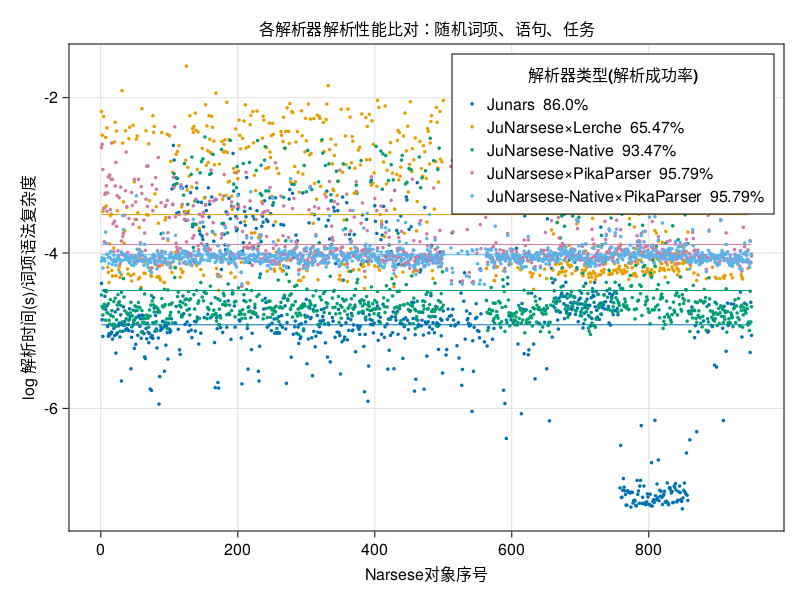

In [50]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    "μₜ($(parser_names[parser])) = $mean_ys" |> println
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()